In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot


In [84]:
import os
results_path = './results'
if not os.path.exists(results_path):
    os.mkdir(results_path)


In [85]:
actions = pd.read_json('../exported/actions.json')
actions['user'] = actions['user'].astype('object')
actions['_id'] = actions['_id'].apply(lambda x: x['$oid'])
actions['time'] = actions['time'].apply(lambda x: x['$date'])
actions['time'] = pd.to_datetime(actions['time'])
actions['time'] = actions['time'].dt.tz_convert("Europe/Warsaw")


In [86]:
users = pd.read_json('../exported/users.json')
users['_id'] = users['_id'].apply(lambda x: x['$oid'])


In [87]:
actions['user_id'] = actions['user'].map(
    lambda userObject: userObject["$oid"], na_action='ignore').astype('object')


In [88]:
actions = actions.merge(users, how='left', left_on='user_id', right_on='_id')


In [89]:
confessions = pd.read_json('../exported/confessions.json')


In [90]:
confessions['createdAt'] = confessions['createdAt'].apply(lambda x: x['$date'])
confessions['createdAt'] = pd.to_datetime(confessions['createdAt'])
confessions['createdAt'] = confessions['createdAt'].dt.tz_convert("Europe/Warsaw")



In [91]:
confessions['_id'] = confessions['_id'].apply(lambda x: x['$oid'])


In [92]:
confessions['actions'] = confessions['actions'].apply(
    lambda x: pd.DataFrame(x))


In [93]:
confessions['actions'] = confessions['actions'].apply(
    lambda actions_df: actions_df.merge(actions, how='left', left_on='$oid', right_on='_id_x'))


In [94]:
moderator_actions_count = actions[['_id_x', 'username']].groupby(
    "username").count().reset_index()
moderator_actions_count = moderator_actions_count.sort_values(
    '_id_x', ascending=False)


In [95]:
moderator_actions_grouped_by_type = actions[['_id_x', 'username', 'type']].groupby(
    ["username", "type"]).count().reset_index()


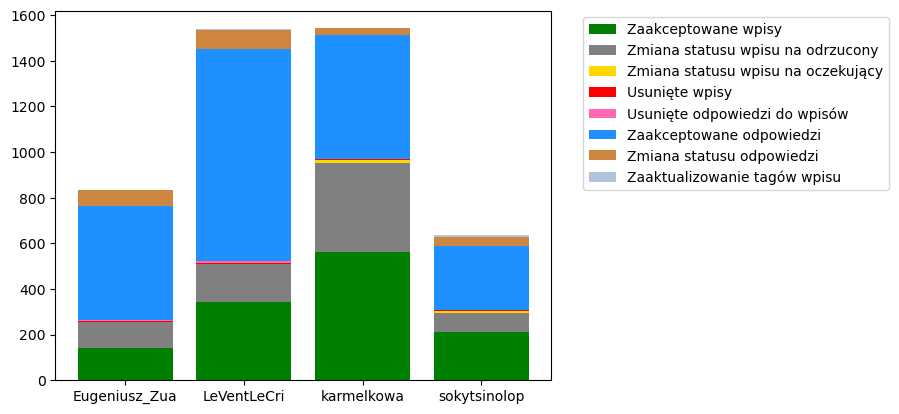

In [96]:
labels = moderator_actions_grouped_by_type['username'].unique()
fig, ax = plot.subplots()

action_label_map = {
    1: 'Zaakceptowane wpisy',
    2: 'Zmiana statusu wpisu na odrzucony',
    3: 'Zmiana statusu wpisu na oczekujący',
    5: 'Usunięte wpisy',
    7: 'Usunięte odpowiedzi do wpisów',
    8: 'Zaakceptowane odpowiedzi',
    9: 'Zaaktualizowanie tagów wpisu',
    10: 'Zmiana statusu odpowiedzi'
}

action_color_map = {
    1: 'green',
    2: 'gray',
    3: 'gold',
    5: 'red',
    7: 'hotpink',
    8: 'dodgerblue',
    9: 'lightsteelblue',
    10: 'peru',
}


bottom = pd.DataFrame([0. for x in labels], columns=['_id_x'], index=labels)

for action_type in moderator_actions_grouped_by_type['type'].unique():
    color = action_color_map[action_type]
    df = moderator_actions_grouped_by_type[moderator_actions_grouped_by_type['type'] == action_type]
    values = df[['username', '_id_x']].set_index('username')
    ax.bar(df['username'], df['_id_x'], bottom=bottom.loc[df['username']]
           ['_id_x'], label=action_label_map[action_type], color=color)
    bottom = bottom.add(values, fill_value=0)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plot.savefig(f'{results_path}/top_mods.png', bbox_inches='tight')
plot.show()


In [97]:
# maybe filter out tags removed by moderator? where tag[1] == 0
confessions['tag_list'] = confessions.apply(
    lambda x: [tag[0] for tag in x['tags']], axis=1)


In [98]:
import string
tag_occurences_list = confessions['tag_list'].explode()
unique, counts = np.unique(tag_occurences_list, return_counts=True)
tag_occurences = list(zip(unique, counts))
tag_occurences = sorted(tag_occurences, key=lambda x: x[1])


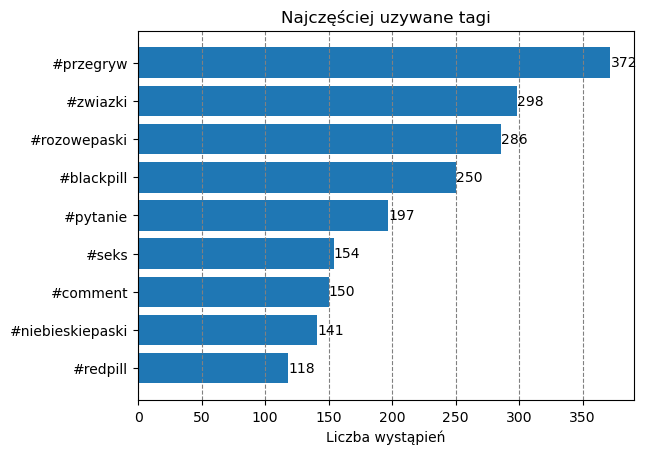

In [99]:
top_tags = tag_occurences[-10:]  # get most used tags
top_tags = top_tags[:-1]  # remove most used tag (#anonimowemirkowyznania)
tag_labes = [x[0] for x in top_tags]
tag_occurences_values = [x[1] for x in top_tags]

fix, ax = plot.subplots()
ax.grid(color='gray', linestyle='dashed', axis='x')

bars = ax.barh(tag_labes, width=tag_occurences_values)
ax.bar_label(bars)
plot.title('Najczęściej uzywane tagi')
plot.xlabel('Liczba wystąpień')

plot.savefig(f'{results_path}/top_tags.png', bbox_inches='tight')
plot.show()


In [100]:
def get_first_mod_action(actions_df):
    # find first index of action of type accept / decline
    idx = actions_df[(actions_df['type'] == 1) | (
        actions_df['type'] == 2)].first_valid_index()
    return actions_df.iloc[[idx]] if idx else None


confessions['1st_mod_action'] = confessions['actions'].map(
    get_first_mod_action).map(lambda x: x['time'].iloc[0], na_action='ignore')
confessions['1st_mod_action'] = pd.to_datetime(confessions['1st_mod_action'], utc=True)


In [101]:
confessions.dtypes

_id                                      object
tags                                     object
status                                    int64
actions                                  object
conversations                            object
text                                     object
IPAdress                                 object
remotePort                                int64
embed                                    object
auth                                     object
createdAt         datetime64[ns, Europe/Warsaw]
updatedAt                                object
__v                                       int64
addedBy                                  object
entryID                                 float64
tag_list                                 object
1st_mod_action              datetime64[ns, UTC]
dtype: object

In [102]:
confessions['reaction_time'] = confessions['1st_mod_action'].subtract(
    confessions['createdAt'])


In [103]:
hours_to_react = confessions['reaction_time'].map(
    lambda x: x.total_seconds() / (60*60))
hours_to_react = hours_to_react[~np.isnan(hours_to_react)]
longest = hours_to_react.max() 
longest_reaction_time = round((longest if not pd.isna(longest) else 0) +0.51)


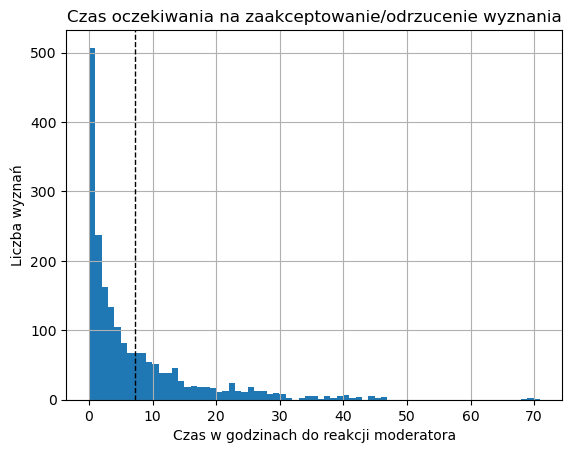

In [104]:
plot.hist(hours_to_react, bins=longest_reaction_time)
plot.xlabel('Czas w godzinach do reakcji moderatora')
plot.ylabel('Liczba wyznań')
plot.title('Czas oczekiwania na zaakceptowanie/odrzucenie wyznania')
plot.grid(True)
plot.axvline(hours_to_react.mean(), color='black',
             linestyle='dashed', linewidth=1)
plot.savefig(f'{results_path}/reaction_time_histogram.png',
             bbox_inches='tight')
plot.show()


In [105]:
replies = pd.read_json('../exported/replies.json')
replies['_id'] = replies['_id'].apply(lambda x: x['$oid'])


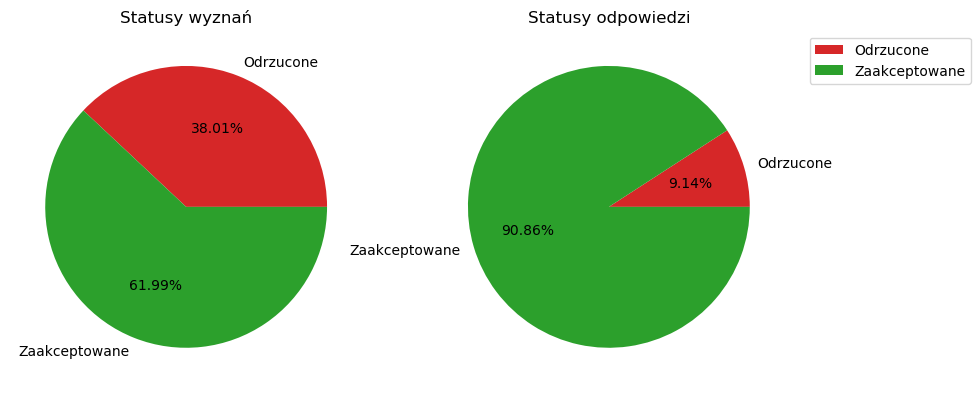

In [106]:
fix, (ax1, ax2) = plot.subplots(1, 2, figsize=(10, 10))

confessions_pie_data = confessions[['_id', 'status']].groupby('status')
replies_pie_data = replies[['_id', 'status']].groupby('status')


status_label_map = {
    -1: 'Odrzucone',
    0: 'Oczekujące',
    1: 'Zaakceptowane'
}
status_color_map = {
    -1: 'tab:red',
    0: 'tab:orange',
    1: 'tab:green'
}


def display_percentage(x):
    return '{:.2f}%'.format(x)


ax1.set_title('Statusy wyznań')
confession_statuses = list(confessions_pie_data.groups.keys())
labels = [status_label_map[status] for status in confession_statuses]
colors = [status_color_map[status] for status in confession_statuses]
ax1.pie(confessions_pie_data.count()[
        '_id'], labels=labels, colors=colors, autopct=display_percentage)


ax2.set_title('Statusy odpowiedzi')
reply_statuses = list(replies_pie_data.groups.keys())
labels = [status_label_map[status] for status in reply_statuses]
colors = [status_color_map[status] for status in reply_statuses]
ax2.pie(replies_pie_data.count()[
        '_id'], labels=labels, colors=colors, autopct=display_percentage)

plot.savefig(f'{results_path}/statuses_pie.png', bbox_inches='tight')
plot.legend(bbox_to_anchor=(1.05, 1))
plot.show()


In [107]:
confessions_added = confessions['_id'].count()
confessions_accepted = confessions[confessions['status'] == 1]['_id'].count()
confessions_declined = confessions[confessions['status'] == -1]['_id'].count()
confessions_waiting = confessions[confessions['status'] == 0]['_id'].count()
confessions_removed = actions[actions['type'] == 5]['_id_x'].count()
avg_reaction_time = confessions['reaction_time'].mean()

confessions_added, confessions_accepted, confessions_declined, confessions_waiting, avg_reaction_time, confessions_removed


(1989, 1233, 756, 0, Timedelta('0 days 07:18:55.329874178'), 20)

In [108]:
replies_added = replies['_id'].count()
replies_accepted = replies[replies['status'] == 1]['_id'].count()
replies_declined = replies[replies['status'] == -1]['_id'].count()
replies_waiting = replies[replies['status'] == 0]['_id'].count()
replies_removed = actions[actions['type'] == 7]['_id_x'].count()

replies_added, replies_accepted, replies_declined, replies_waiting, replies_removed


(2461, 2236, 225, 0, 14)

In [109]:
heatmap = confessions['_id'].groupby([confessions['createdAt'].dt.date, confessions['createdAt'].dt.hour])

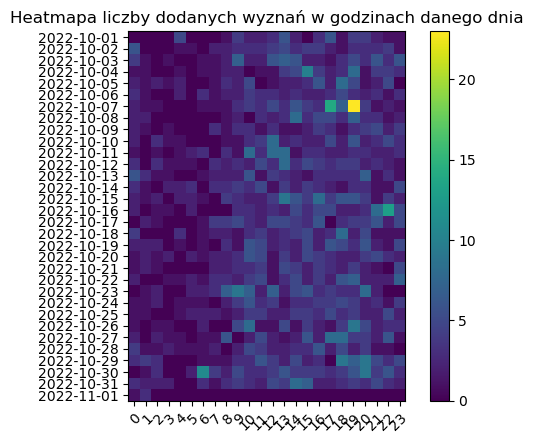

In [117]:
def get_count_for_date_and_hour(date,hour):
    try:
        df = heatmap.get_group((date,hour))
    except KeyError:
        return 0
    return df.count()

heatmap_days = pd.unique(heatmap.keys[0])
heatmap_hours = pd.array([*range(0,24)])

data_array = np.array([[get_count_for_date_and_hour(d,h) for h in heatmap_hours] for d in heatmap_days])

fig, ax = plot.subplots()
im = ax.imshow(data_array)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(heatmap_hours)), labels=heatmap_hours)
ax.set_yticks(np.arange(len(heatmap_days)), labels=heatmap_days)

# Rotate the tick labels and set their alignment.
plot.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Create colorbar
cbar = ax.figure.colorbar(im)

ax.set_title("Heatmapa liczby dodanych wyznań w godzinach danego dnia")
plot.savefig(f'{results_path}/hour_distribution_heatmap.png',
             bbox_inches='tight')
plot.show()

In [111]:
modActivityData = actions[(actions['type'] == 8) | (actions['type'] == 1)]['_id_x'].groupby([actions['time'].dt.date, actions['time'].dt.hour])


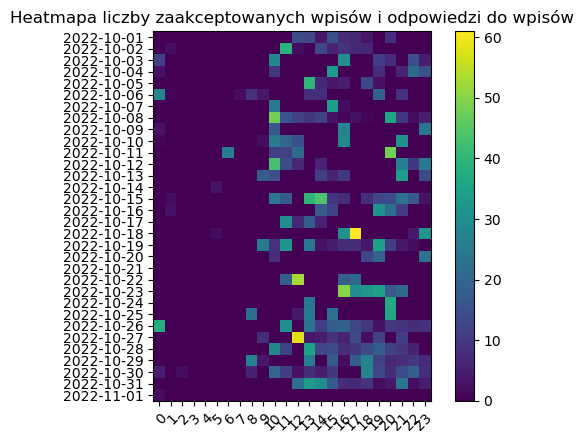

In [118]:
def get_count_for_date_and_hour(date,hour):
    try:
        df = modActivityData.get_group((date,hour))
    except KeyError:
        return 0
    return df.count()

heatmap_days = pd.unique(modActivityData.keys[0])
heatmap_hours = pd.array([*range(0,24)])

data_array = np.array([[get_count_for_date_and_hour(d,h) for h in heatmap_hours] for d in heatmap_days])
data_array
fig, ax = plot.subplots()
im = ax.imshow(data_array)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(heatmap_hours)), labels=heatmap_hours)
ax.set_yticks(np.arange(len(heatmap_days)), labels=heatmap_days)

# Rotate the tick labels and set their alignment.
plot.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Create colorbar
cbar = ax.figure.colorbar(im)

ax.set_title("Heatmapa liczby zaakceptowanych wpisów i odpowiedzi do wpisów")
plot.savefig(f'{results_path}/mod_activity_heatmap.png',
             bbox_inches='tight')
plot.show()

In [ ]:
f = open(f"./{results_path}/result_text.txt", "w")
since = os.getenv('SINCE')
until = os.getenv('UNTIL')
period = os.getenv('PERIOD')
f.write(f"""
#anonimowemirkowyznaniastatystyki #amwstats{period}
Statystyki z okresu ({since}, {until}):
Dodane wyznania: {confessions_added}
Zaakceptowane wyznania: {confessions_accepted}
Odrzucone wyznania: {confessions_declined}
Oczekujące wyznania: {confessions_waiting}
Usunięte wyznania (niewliczone są wpisy usunięte przez moderatorów wykopa): {confessions_removed}
średni czas oczekiwania na dodanie wydania: {avg_reaction_time}
---
Dodane odpowiedzi: {replies_added}
Zaakceptowane odpowiedzi: {replies_accepted}
Odrzucone odpowiedzi: {replies_declined}
Oczekujące odpowiedzi: {replies_waiting}
Usunięte odpowiedzi (niewliczone są odpowiedzi usunięte przez moderatorów wykopa): {replies_removed}


!// source: github.com/cymruu/amw_stats
""")
f.close()
